In [1]:
import numpy as np
import pandas as pd
# import tensorflow as tr
# from tensorflow import keras
import os
import matplotlib.image as mpimg

# VALIDATE DATA
Ensuring files and Sheets have equal values


In [2]:
file =pd.read_csv("data/test_meta-v.csv")
#file paths
test_dir="data/test/"
train_dir="data/train/"
#meta record paths
meta_train_dir="data/train_meta-v.csv"
meta_test_dir="data/test_meta-v.csv"
#original record paths
org_train_dir=""
org_test_dir=""


def compareFiles(file_path,record_path):
    #prepare sheets
    data = pd.DataFrame(pd.read_csv(record_path))
    # data.head()
    names = data['image_id'] 
    count =0
    # compare png files and records in the Excel sheets
    with os.scandir(file_path)as files:
        for file in files:
            if(str(file.name)!=str(names[count])+".png"):
                print("Inconsistent on line "+str(count)+" for image "+str(file.name)+" and record "+str(names[count])+".png")
            count+=1  
    # Records v files may not be equal
    if(count==len(names)):
        print("Files and folders are equal")
        print(str(count)+" "+str(len(names))) 
    elif(count<len(names)):
        print("File missing")
        print("Files: "+str(count)+" Records: "+str(len(names)))
    elif(count>len(names)):
        print("Record missing")
        print("Files: "+str(count)+" Records: "+str(len(names)))
    

compareFiles(test_dir,meta_test_dir)
compareFiles(train_dir,meta_train_dir)


Files and folders are equal
3000 3000
Files and folders are equal
15000 15000


In [3]:
#png dataset
test_dir="data/test/"
train_dir="data/train/"
#original dicom dataset
org_train_dir="data/original/train"
org_test_dir="data/original/test"
#png datasize same resolution as dicom dataset
variant_dir="data/variant"

Files found:1


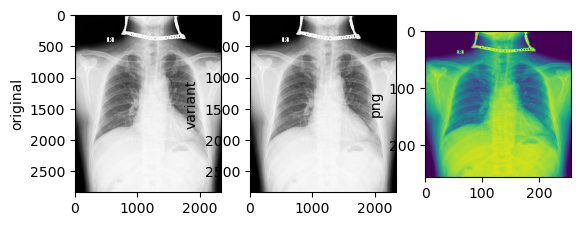

In [4]:
# preprocessing 
# def image-processor(image, size):
# Set mean image size as desired image size for all images in the img list
# Make images black and white  
# def image-processor(image, coords):
# Compare original images and currnet images b-box

#key = 000434271f63a053c4128a0ba6352c7f
#search dir for img matching{----} and draw the b-box on
! pip install pydicom
from os import O_RDONLY
from matplotlib import pyplot as plt
import pydicom as pdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def search(key):
    count = 0
    files = os.scandir(train_dir)
    ax, (fig1, fig2, fig3) = plt.subplots(1,3)
    for file in files:
        if(str(file.name)==key+".png"):
            dicom = pdm.dcmread(org_train_dir+"/"+str(key)+".dicom")
            fig1.imshow(dicom.pixel_array,cmap=plt.cm.Greys)
            fig1.set_ylabel("original")

            fig2.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
            fig2.set_ylabel("variant")

            fig3.imshow(mpimg.imread(train_dir+"/"+key+".png"))
            fig3.set_ylabel("png")
            # ax.plot(fig1,fig2)
           
            count+=1
            print("Files found:"+ str(count))
            plt.show()
    if(count==0):
        print(count)
        print("no file found")

search(key = "000434271f63a053c4128a0ba6352c7f")


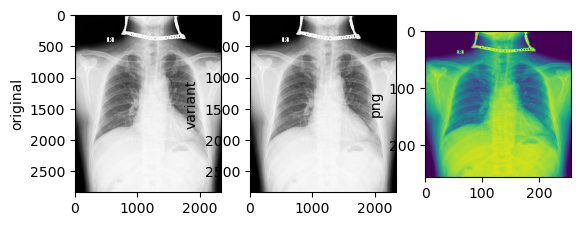

In [5]:
test_dir="data/test/"
train_dir="data/train/"

org_train_dir="data/original/train"
org_test_dir="data/original/test"

variant_dir="data/variant"

import pydicom as pdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#convert from dicom to png
key ="000434271f63a053c4128a0ba6352c7f"
#read the dicom image using pydicom as pdm
ax, (fig1, fig2, fig3) = plt.subplots(1,3)
dicom = pdm.dcmread(org_train_dir+"/"+key+".dicom")
fig1.imshow(dicom.pixel_array,cmap=plt.cm.Greys)
fig1.set_ylabel("original")

fig2.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
fig2.set_ylabel("variant")

fig3.imshow(mpimg.imread(train_dir+"/"+key+".png"))
fig3.set_ylabel("png")
# ax.plot(fig1,fig2)
plt.show()


In [6]:
%pwd

'c:\\Users\\Samson\\Documents\\code\\cp2\\ml-chest-xray-annotator'

In [7]:
#drawing coords using matplotlib patches
# import pandas as pd
train_data = pd.read_csv("data/train - Copy.csv")
train_data.set_index(train_data.index)
train_data.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [8]:
train_data.describe()

,class_id,x_min,y_min,x_max,y_max
count,67914.000000,36096.000000,36096.000000,36096.000000,36096.000000
mean,9.979312,1051.332696,1065.262051,1492.269337,1456.660489
std,5.036494,565.838078,552.925133,595.384126,581.134138
min,0.000000,0.000000,0.000000,68.000000,103.000000
25%,7.000000,602.000000,627.000000,1010.000000,1009.000000
50%,13.000000,1014.500000,935.000000,1567.000000,1411.000000
75%,14.000000,1457.000000,1471.000000,1947.000000,1911.000000
max,14.000000,2934.000000,3133.000000,3131.000000,3384.000000


In [9]:
train_data.isna().sum()

image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
dtype: int64

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [11]:
train_data.convert_dtypes
train_data['image_id'].astype(str)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [12]:
train_data['b-width']  = train_data['x_max']-train_data['x_min']
train_data['b-height'] = train_data['y_max']-train_data['y_min']

train_data.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,b-width,b-height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,962.0,456.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,347.0,276.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train_data['b-width']= train_data['b-width'].replace(np.nan,0)
train_data['b-height']= train_data['b-height'].replace(np.nan,0)
train_data.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,b-width,b-height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,0.0,0.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,0.0,0.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,962.0,456.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,347.0,276.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,0.0,0.0


In [14]:
%pip install opencv-python
import cv2
def plot( id, abnorm):
   data = train_data.loc[(train_data['image_id']==id) & (train_data['class_id'] == abnorm)]
   index = data.index
   width = data['b-width']
   path="data/variant/"+id+".png"
   image = cv2.imread(path)
   # print(image)
  #plt.patches.Rectangle([data['x-min'],data['y-min']],data['b-width'],data['b-height'])

   cv2.imshow("original",image)

# plot('9a5094b2563a1ef3ff50dc5c7ff71345',3)
plot('000434271f63a053c4128a0ba6352c7f',3)

Note: you may need to restart the kernel to use updated packages.


In [15]:
healthy = train_data[train_data['class_id']==14].count()
healthy

image_id      31818
class_name    31818
class_id      31818
rad_id        31818
x_min             0
y_min             0
x_max             0
y_max             0
b-width       31818
b-height      31818
dtype: int64

In [16]:
classes ={ 0:"Aortic enlargement",
1:"Atelectasis",
2: "Calcification",
3: "Cardiomegaly",
4: "Consolidation",
5: "ILD",
6: "Infiltration",
7: "Lung Opacity",
8: "Nodule/Mass",
9: "Other lesion",
10: "Pleural effusion",
11: "Pleural thickening",
12: "Pneumothorax",
13: "Pulmonary fibrosis",
14:"No finding"}
print (classes[14])

No finding


<https://machinelearningmastery.com/three-ways-to-build-machine-learning-models-in-keras/>


There are different types of layers : 
Dense layer connects input and output layers
convolutional layers better for image processing
Pooling layers
Recurrent layers better for time series
Normalization Layers


In [17]:
def residual_block(x,filters):
    identity = x
    x = Conv2D(filters=filters,kernel_size=(3,3), strides = (1,1), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(filters=filters,kernel_size=(3,3), padding ="same")(x)
    x = Add()([identity,x])
    x = relu(x)
    return x

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D,Add
from keras.activations import relu
from keras.optimizers import Adam
from tensorflow.keras.models import Model
#input layer
input_layer = Input(shape=(32,32,3,))
#first convolutional layer
x = Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu")(input_layer)
#first residual block
x = residual_block(x,32)
#secondd convolutional layer
x = Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(x)
# second residual layer
x = residual_block(x,64)
#third convolutional layer
x = Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(x)
#first slattening layer
x = Flatten()(x)
#first dense layer
x = Dense(units=84, activation ="relu")(x)
#second dense layer
x = Dense(units=10, activation = "softmax")(x)

#create model without pur in form of X
model = Model(inputs=input_layer, outputs = x)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d_1[0][0]']               
 alization)                                                                                   